# LSTM LONG-SHORT TERM MEMORY ile HİSSE SENEDİ TAHMİNİ
LSTM RNN yapısının daha hafızılaı hali gibidir.

1- Problem

2- Veriyi anlamak

3- Veriyi hazırlamak

4- Modelleme

5- Değerlendirme - Evalution

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
df = pd.read_csv("/TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [7]:
# veri setini incelemek için

def check_df(dataframe, head=5):
  print("##################### Shape #####################")
  print(dataframe.shape)
  print("##################### Types #####################")
  print(dataframe.dtypes)
  print("##################### Head #####################")
  print(dataframe.head(head))
  print("##################### Tail #####################")
  print(dataframe.tail(head))
  print("##################### NA #####################")
  print(dataframe.isnull().sum())
  print("##################### Describe #####################")
  # Select only numeric columns for quantile calculation
  numeric_df = dataframe.select_dtypes(include=['number'])
  print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [8]:
  check_df(df)

##################### Shape #####################
(2416, 7)
##################### Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
##################### Head #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
##################### Tail #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575

In [9]:
# Tarih değişkenini object ten tarih tipine değiştiriyoruz

df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [11]:
# Date i index olarak tanımlıyoruz

tesla_df = df.copy()

tesla_df.index = df['Date']
tesla_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-06-29,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [12]:
# değişkenlerin arasından date i kaldırıyoruz

tesla_df.drop('Date', axis=1, inplace=True)
tesla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [13]:
result_df = tesla_df.copy()

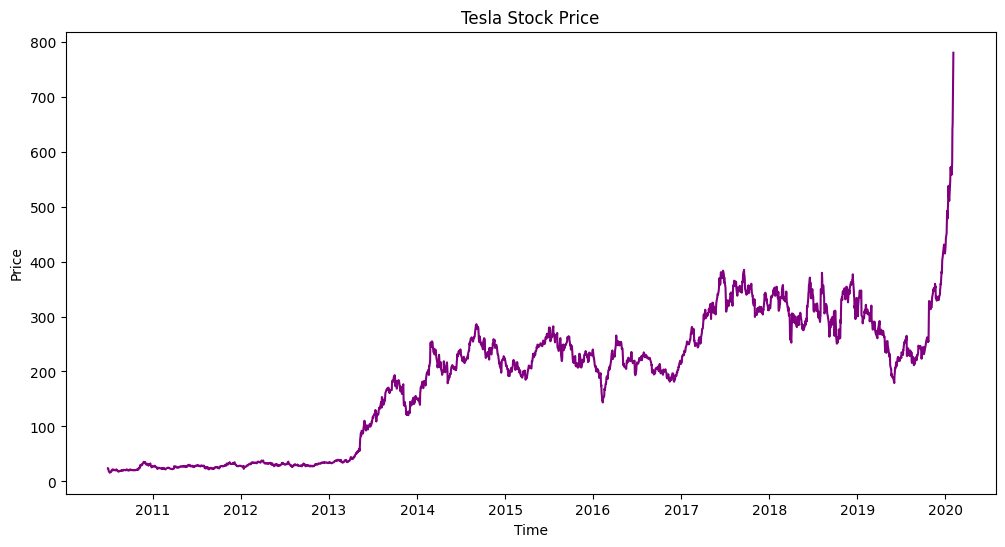

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_df['Close'], color='purple')
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [16]:
# modelde kullanmak için numpy a dönüştürüyoruz

tesla_df = tesla_df.values
tesla_df[0:5]

array([[1.9000000e+01, 2.5000000e+01, 1.7540001e+01, 2.3889999e+01,
        2.3889999e+01, 1.8766300e+07],
       [2.5790001e+01, 3.0420000e+01, 2.3299999e+01, 2.3830000e+01,
        2.3830000e+01, 1.7187100e+07],
       [2.5000000e+01, 2.5920000e+01, 2.0270000e+01, 2.1959999e+01,
        2.1959999e+01, 8.2188000e+06],
       [2.3000000e+01, 2.3100000e+01, 1.8709999e+01, 1.9200001e+01,
        1.9200001e+01, 5.1398000e+06],
       [2.0000000e+01, 2.0000000e+01, 1.5830000e+01, 1.6110001e+01,
        1.6110001e+01, 6.8669000e+06]])

In [18]:
# Train - Test set ayrımı: zaman kavramı olduğu için manuel olarak ayırmamız gerekiyor, data ayırma fonksiyonu rastgele ayırır.

def split_data(dataframe, test_size):
    pos = int(round( len(dataframe)*(1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [19]:
train, test, pos = split_data(tesla_df, 0.2)

In [20]:
print(train.shape, test.shape)

(1933, 6) (483, 6)


In [22]:
# performans arttırmak için değişkenleri standatlaştırıyoruz

scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [23]:
train[0:5]

array([[0.00771826, 0.02244089, 0.00702583, 0.02191224, 0.02191224,
        0.50337694],
       [0.02604237, 0.0369725 , 0.02283393, 0.02174973, 0.02174973,
        0.46074816],
       [0.02391041, 0.02490751, 0.01451821, 0.01668472, 0.01668472,
        0.21865873],
       [0.01851302, 0.01734678, 0.01023684, 0.0092091 , 0.0092091 ,
        0.13554449],
       [0.01041695, 0.00903534, 0.00233279, 0.00083966, 0.00083966,
        0.18216567]])

In [24]:
test[0:5]

array([[0.30713171, 0.25201014, 0.3067287 , 0.25685907, 0.25685907,
        0.03045332],
       [0.3098926 , 0.24970806, 0.30217709, 0.24829045, 0.24829045,
        0.04080997],
       [0.29302259, 0.24325226, 0.29152313, 0.25511204, 0.25511204,
        0.05698956],
       [0.30808579, 0.24458678, 0.30064645, 0.24978787, 0.24978787,
        0.02467746],
       [0.29030228, 0.23656289, 0.29279195, 0.24657673, 0.24657673,
        0.06818926]])

In [25]:
# t zamanındaki değerler tahmin edilirken t-1 anındaki değerleri en çok etkili olur

def create_feature(data, lookback):
  x, y = [], []
  for i in range(lookback, len(data)):
    x.append(data[i-lookback:i, 0])
    y.append(data[i, 0])
  return np.array(x), np.array(y)

In [26]:
lookback = 20 # 20 günlük periyotlar

# Train veri seti
x_train, y_train = create_feature(train, lookback)
# Test veri seti
x_test, y_test = create_feature(test, lookback)

In [27]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1913, 20) (1913,)
(463, 20) (463,)


In [28]:
# Veriyi 3d hale getirme

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1913, 20, 1) (1913, 1) (463, 20, 1) (463, 1)


In [31]:
# Modelleme

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], 1))) # Changed input_shape to (x_train.shape[1], 1)
model.add(Dropout(0.2)) # aşırı öğrenmeyi engeller
model.add(Dense(1)) # nöronlar
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Optimizasyon ve değerlendirme metrikleri

model.compile(optimizer='adam', loss='mse')

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1, save_weights_only=False)]

history = model.fit(x_train, y_train, epochs=50, batch_size=20, validation_data=(x_test, y_test), callbacks=callbacks, shuffle=False)

Epoch 1/50
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069
Epoch 1: val_loss improved from inf to 0.02108, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0072 - val_loss: 0.0211
Epoch 2/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0209
Epoch 2: val_loss improved from 0.02108 to 0.00839, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0208 - val_loss: 0.0084
Epoch 3/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0109
Epoch 3: val_loss improved from 0.00839 to 0.00418, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0109 - val_loss: 0.0042
Epoch 4/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045
Epoch 4: val_loss improved from 0.00418 to 0.00254, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022
Epoch 5: val_loss improved from 0.00254 to 0.00216, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 6: val_loss improved from 0.00216 to 0.00215, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/50
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 7: val_loss improved from 0.00215 to 0.00189, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/50
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 8: val_loss did not improve from 0.00189
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 9/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 9: val_loss did not improve from 0.00189
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 10/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 10: val_loss did not improve from 0.00189
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 10: early stopping


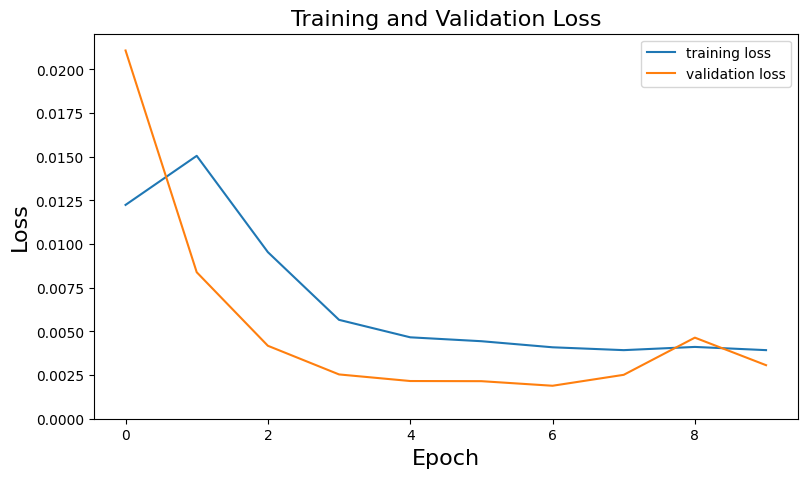

In [33]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim(0, max(plt.ylim()))
plt.show()

In [36]:
# Evaluation
# Gerçek değerlere çevirirerek inceleme

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Reshape before inverse_transform to match the original data shape
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# Assuming scaler_train was fitted on a dataset with 6 features
# Create a temporary array with the correct number of features for inverse_transform
num_original_features = 6  # Replace 6 with the actual number of features in your original data
train_predict_temp = np.zeros((train_predict.shape[0], num_original_features))
test_predict_temp = np.zeros((test_predict.shape[0], num_original_features))

# Put the predicted values into the first column of the temporary array
train_predict_temp[:, 0] = train_predict[:, 0]
test_predict_temp[:, 0] = test_predict[:, 0]

# Apply inverse_transform on the temporary array
train_predict = scaler_train.inverse_transform(train_predict_temp)[:, 0]
test_predict = scaler_train.inverse_transform(test_predict_temp)[:, 0]

# Instead of directly inverse transforming y_train and y_test, create temporary arrays:
y_train_temp = np.zeros((y_train.shape[0], num_original_features))
y_test_temp = np.zeros((y_test.shape[0], num_original_features))

# Fill the first column with the original y values
y_train_temp[:, 0] = y_train[:, 0]
y_test_temp[:, 0] = y_test[:, 0]

# Apply inverse_transform on the temporary arrays and extract the first column
y_train = scaler_train.inverse_transform(y_train_temp)[:, 0]
y_test = scaler_train.inverse_transform(y_test_temp)[:, 0]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [37]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print("Train RMSE:", train_rmse)

Train RMSE: 0.03762912436878368


In [38]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print("Test RMSE:", test_rmse)

Test RMSE: 0.05536840792521959


In [39]:
# görselleştirme

train_prediction_df = result_df[lookback:pos]
train_prediction_df['Predicted'] = train_predict
train_prediction_df.head()

,Open,High,Low,Close,Adj Close,Volume,Predicted
Date,,,,,,,
2010-07-28,20.549999,20.900000,20.510000,20.719999,20.719999,467200,0.064904
2010-07-29,20.770000,20.879999,20.000000,20.350000,20.350000,616000,0.064880
2010-07-30,20.200001,20.440001,19.549999,19.940001,19.940001,426900,0.064868
2010-08-02,20.500000,20.969999,20.330000,20.920000,20.920000,718100,0.064808
2010-08-03,21.000000,21.950001,20.820000,21.950001,21.950001,1230500,0.064792


In [40]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Open,High,Low,Close,Adj Close,Volume,Predicted
Date,,,,,,,
2018-04-03,269.820007,273.350006,254.490005,267.529999,267.529999,18844400,0.262524
2018-04-04,252.779999,288.369995,252.000000,286.940002,286.940002,19896700,0.254795
2018-04-05,289.339996,306.260010,288.200012,305.720001,305.720001,19121100,0.242578
2018-04-06,301.000000,309.279999,295.500000,299.299988,299.299988,13520300,0.244780
2018-04-09,300.369995,309.500000,289.209991,289.660004,289.660004,10249800,0.250655


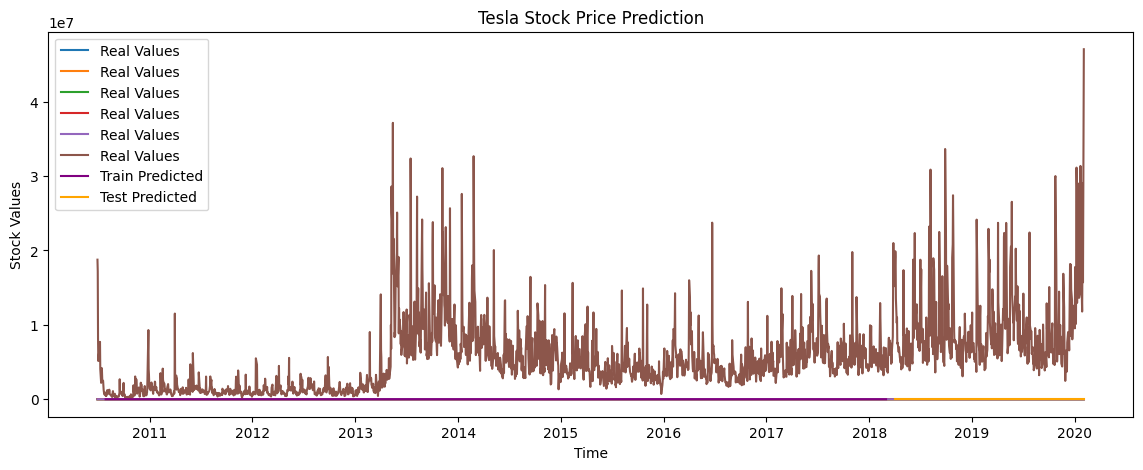

In [42]:
plt.figure(figsize=(14, 5))
plt.plot(result_df, label="Real Values")
plt.plot(train_prediction_df['Predicted'], label='Train Predicted', color='purple')
plt.plot(test_prediction_df['Predicted'], label='Test Predicted', color='orange')
plt.title("Tesla Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()